# Seller Segmentation
The goal of this notebook is to provide an overview of the steps that are done in the seller segmentation. In the first part each of the steps is described. The second part is the condensed code that can be used at a higher level for example to run further experiments or inference.

In [52]:
import os
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from numpy import std

import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime

from google.cloud import bigquery

from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from collections import Counter, defaultdict

from k_means_constrained import KMeansConstrained

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

## Part 1: Segmentation Steps
The main steps for runnung the segmentation training are:
1. Extract the training data
2. Preprocess and prepare the features
3. Filter the features
    - Remove zero (and low) variance features
    - Correlation Filter
    - Run PCA and get first components that describe 80% of variance
    - Extract top (absolute) x features of the selected PCA components
4. Run K-Means clustering
5. Export the results

In [53]:
cwd = os.getcwd()
cwd

'/home/jupyter/eser/notebook'

In [54]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

### Step 1: Extract the training data
The training data is stored in BigQuery. The query for getting the training data out of BigQuery is located in `../sql/training_data.sql`. To query the data a BQ python client is created and the query is executed.

In [55]:
#bqclient = bigquery.Client(project='ci-cre-prod')
bqclient = bigquery.Client()
script_path = os.path.join('../sql', 'training_data.sql')
with open(script_path, 'r') as fd:
    query_string = fd.read()
    seller_base_df = bqclient.query(query_string).result().to_dataframe()
seller_base_df.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [57]:
seller_base_df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
shop_id,729.0,NaN,NaN,NaN,3118.550069,840.586096,2006.0,2463.0,2845.0,4131.0,4563.0
months_with_conrad,729.0,NaN,NaN,NaN,29.020576,16.9114,6.0,14.0,27.0,40.0,73.0
is_fds,729,2,False,654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_to_first_sale,497.0,NaN,NaN,NaN,142.450704,161.866489,7.0,43.0,90.0,181.0,1375.0
offers_active_mp_total,729.0,NaN,NaN,NaN,10820.958848,48851.628284,0.0,0.0,28.0,1337.0,550065.0
offers_active_mp_ict,729.0,NaN,NaN,NaN,2660.631001,17408.558816,0.0,0.0,0.0,97.0,354438.0
offers_active_mp_mro,729.0,NaN,NaN,NaN,6460.751715,32450.264455,0.0,0.0,0.0,200.0,526442.0
offers_active_mp_bssa,729.0,NaN,NaN,NaN,1647.155007,12649.854184,0.0,0.0,0.0,40.0,235285.0
offers_active_mp_none,729.0,NaN,NaN,NaN,52.421125,539.367766,0.0,0.0,0.0,0.0,10302.0
offers_inactive_mp_total,729.0,NaN,NaN,NaN,45715.462277,485662.797133,0.0,0.0,34.0,1998.0,11955847.0


In [5]:
seller_df = seller_base_df.copy()
seller_df.shape, seller_base_df.shape

((729, 328), (729, 328))

### Step 2: Preprocess and prepare the features
Preprocessing the features is an important step before doing training. We for example want to handle NA values, do standard scaling (μ = 0 and σ = 1) and it is also to convert object type features to categorical features.

In order to save the improvements from manual processing, the data is split with an automatic method that distinguishes according to object types.

All the features are described in https://docs.google.com/spreadsheets/d/1wttgCyjF9eMlExHulzLslK898wP6v2eOrz3gvBR9wgI/edit#gid=436055984

In [6]:
#percentage of missing values in each variables
missing_features = []
for col in seller_df.columns:
    if (seller_df[col].isnull().sum() / len(seller_df[col]) * 100 > 0):
        missing_features.append(col)
missing_features

['date_first_order', 'days_to_first_sale']

In [7]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numerics = ['object', 'boolean', 'dbdate']


numeric_df = seller_df.select_dtypes(include=numerics)
non_numerics_df = seller_df.select_dtypes(include=non_numerics)


for col in numeric_df.columns:
    numeric_df[col].replace({np.nan: 0}, inplace = True)


numeric_df.shape, seller_df.shape

((729, 323), (729, 328))

### Step 2: Filter the features
Only meaningful features should be used by the model.

Start with zero/low variance filtering.

Setting threshold as 0.0001

In [8]:
#Normalize data
normalized = normalize(numeric_df)
data_Scaled = pd.DataFrame(normalized)

#Storing the data variance and name of variables
variance = data_Scaled.var()
columns = numeric_df.columns

In [9]:
#Saving the names of variables having variance mre than a threshold value
variables = []
variance_threshold = 0.0001 #Setting threshold as 0.0001
for i in range(0, len(variance)):
    if variance[i]> variance_threshold:
        variables.append(columns[i])

In [10]:
non_numerics_col_list = non_numerics_df.columns

In [11]:
#col_list = non_numerics_col_list + variables
for x in non_numerics_col_list:
    variables.append(x)
len(variables)

88

In [12]:
#Creating new data frame with using the variables above
seller_df = seller_df[variables]
seller_df.shape

(729, 88)

In [13]:
seller_df.shape

(729, 88)

In [14]:
#Remove shop state from model
seller_df = seller_df.drop(['shop_state'], axis=1)
seller_df.head()


,shop_id,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_6m_total,ordered_units_mp_6m_mro,ordered_units_mp_12m_total,ordered_units_mp_12m_ict,ordered_units_mp_12m_mro,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_3m_total,sales_mp_3m_ict,sales_mp_3m_mro,sales_mp_3m_bssa,sales_mp_6m_total,sales_mp_6m_ict,sales_mp_6m_mro,sales_mp_6m_bssa,sales_mp_6m_none,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_total,sales_oci_6m_ict,sales_oci_6m_mro,sales_oci_12m_total,sales_oci_12m_ict,sales_oci_12m_mro,sales_oci_12m_bssa,commmission_mp_3m_total,commmission_mp_6m_total,commmission_mp_6m_ict,commmission_mp_6m_mro,commmission_mp_6m_bssa,commmission_mp_12m_total,commmission_mp_12m_ict,commmission_mp_12m_mro,commmission_mp_12m_bssa,pdp_active_1m_total,pdp_active_3m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_active_3m_bssa,pdp_active_6m_total,pdp_active_6m_ict,pdp_active_6m_mro,pdp_active_6m_bssa,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_1m_total,pdp_inactive_1m_ict,pdp_inactive_3m_total,pdp_inactive_3m_ict,pdp_inactive_3m_mro,pdp_inactive_3m_bssa,pdp_inactive_6m_total,pdp_inactive_6m_ict,pdp_inactive_6m_mro,pdp_inactive_6m_bssa,pdp_inactive_6m_none,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,pdp_inactive_12m_none,date_created,is_fds,date_first_order,company_type
0,2509,0,0,0,0,0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-08,False,NaT,Co. KG
1,2154,49,0,0,0,0,505977,10,18156,487633,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,833,0,2931,0,537,2394,7998,0,1139,6859,0,13411,1,1413,11997,0,2018-07-27,False,2018-09-14,other
2,2915,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-04-28,False,NaT,GmbH
3,4452,0,0,0,0,0,2,0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,17,0,0,17,19,0,0,19,0,19,0,0,19,0,2022-09-07,False,NaT,Co. KG
4,2889,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-03-26,False,NaT,Co. KG


In [15]:
seller_df.columns

Index(['shop_id', 'days_to_first_sale', 'offers_active_mp_total',
       'offers_active_mp_ict', 'offers_active_mp_mro', 'offers_active_mp_bssa',
       'offers_inactive_mp_total', 'offers_inactive_mp_ict',
       'offers_inactive_mp_mro', 'offers_inactive_mp_bssa',
       'offers_active_oci_total', 'offers_active_oci_mro',
       'ordered_units_mp_3m_total', 'ordered_units_mp_3m_mro',
       'ordered_units_mp_6m_total', 'ordered_units_mp_6m_mro',
       'ordered_units_mp_12m_total', 'ordered_units_mp_12m_ict',
       'ordered_units_mp_12m_mro', 'sales_mp_1m_total', 'sales_mp_1m_ict',
       'sales_mp_1m_mro', 'sales_mp_1m_bssa', 'sales_mp_3m_total',
       'sales_mp_3m_ict', 'sales_mp_3m_mro', 'sales_mp_3m_bssa',
       'sales_mp_6m_total', 'sales_mp_6m_ict', 'sales_mp_6m_mro',
       'sales_mp_6m_bssa', 'sales_mp_6m_none', 'sales_mp_12m_total',
       'sales_mp_12m_ict', 'sales_mp_12m_mro', 'sales_mp_12m_bssa',
       'sales_mp_12m_none', 'sales_oci_3m_total', 'sales_oci_6m_total',
 

In [16]:
#Convert company type as a categorical version
company_type_dictionary = dict(zip(seller_df['company_type'].unique() , np.arange(1, len(seller_df['company_type'].unique()) + 1, 1).tolist()))
seller_df['company_type'] = seller_df['company_type'].map(company_type_dictionary)
seller_df['company_type'].nunique()

4

In [17]:
#Fill Nat date features to irrelevant date
for col in seller_df.select_dtypes(include=['dbdate']).columns:
    print(col)
    seller_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_df[col] = pd.to_datetime(seller_df[col])

date_created
date_first_order


In [18]:
#Split date features into day, month and year
seller_df["date_created_day"] = seller_df['date_created'].map(lambda x: x.day)
seller_df["date_created_month"] = seller_df['date_created'].map(lambda x: x.month)
seller_df["date_created_year"] = seller_df['date_created'].map(lambda x: x.year)
seller_df.drop(columns=["date_created"], axis=1, inplace=True)
##############
seller_df["date_first_order_day"] = seller_df['date_first_order'].map(lambda x: x.day)
seller_df["date_first_order_month"] = seller_df['date_first_order'].map(lambda x: x.month)
seller_df["date_first_order_year"] = seller_df['date_first_order'].map(lambda x: x.year)
seller_df.drop(columns=["date_first_order"], axis=1, inplace=True)

**Next step is correlation filtering.**

In [19]:
# do variance filtering based on a threshold
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def correlation_filter(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print("drop %d features" % len(to_drop))
    df.drop(to_drop, axis=1, inplace=True)
    
    return df
    
seller_df = correlation_filter(seller_df, threshold=0.95)
seller_df.head()

drop 56 features


,shop_id,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,2509,0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,8,1,2020,1,1,1999
1,2154,49,0,0,0,0,505977,18156,487633,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,537,False,2,27,7,2018,14,9,2018
2,2915,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,3,28,4,2021,1,1,1999
3,4452,0,0,0,0,0,2,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,7,9,2022,1,1,1999
4,2889,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,26,3,2021,1,1,1999


**PCA Analyse**

In [20]:
# do feature selection based on PCA
def pca_feature_selection(df, threshold, max_features):
    # threshold should be max 1
    threshold = 1.0 if threshold > 1.0 else threshold
    
    num_features_input = len(df.columns)
    print("got %d features" % num_features_input)
    
    pca_model = PCA(n_components=num_features_input)
    pca_model.fit_transform(df)
    
    # calculate min number of components explaining threshold variance
    number_of_components = 1
    cumsum = pca_model.explained_variance_ratio_.cumsum()
    
    while cumsum[number_of_components - 1] <= threshold:
        number_of_components += 1
        
    print("%d components describe >0.8 variance" % number_of_components)
    
    # calculate features per component based on max_features
    features_per_component = int(max_features / number_of_components) + 1
    features_per_component = num_features_input if features_per_component > num_features_input else features_per_component
    
    print("finding highest %d feature values per component" % features_per_component)
    
    features_to_include = []

    for component_index in range(number_of_components):
        component = pca_model.components_[component_index]
        
        values_with_indeces = [[i, v] for i, v in enumerate(component)]
        
        values_with_indeces_sorted = sorted(values_with_indeces, key=lambda x: x[1], reverse=True)
        
        top_x_indeces = [i for [i, v] in values_with_indeces_sorted][:features_per_component]
        top_x_values = [v for [i, v] in values_with_indeces_sorted][:features_per_component]
        
        features_to_include += top_x_indeces
        
    # only unique indeces
    features_to_include = list(set(features_to_include))
    
    # drop end of list if there are more than max_features
    features_to_include = features_to_include[:max_features] if len(features_to_include) < max_features else features_to_include
    df = df[[df.columns[i] for i in features_to_include]]
    
    print("%d features are remaining" % len(df.columns))
    
    return df
    
seller_df = pca_feature_selection(seller_df, 0.8, 50)


got 35 features
1 components describe >0.8 variance
finding highest 35 feature values per component
35 features are remaining


In [21]:
seller_df.head()

,shop_id,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,2509,0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,8,1,2020,1,1,1999
1,2154,49,0,0,0,0,505977,18156,487633,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,537,False,2,27,7,2018,14,9,2018
2,2915,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,3,28,4,2021,1,1,1999
3,4452,0,0,0,0,0,2,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,7,9,2022,1,1,1999
4,2889,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,False,1,26,3,2021,1,1,1999


In [22]:
seller_df.columns

Index(['shop_id', 'days_to_first_sale', 'offers_active_mp_total',
       'offers_active_mp_ict', 'offers_active_mp_mro', 'offers_active_mp_bssa',
       'offers_inactive_mp_total', 'offers_inactive_mp_mro',
       'offers_inactive_mp_bssa', 'offers_active_oci_total',
       'offers_active_oci_mro', 'ordered_units_mp_3m_total',
       'ordered_units_mp_3m_mro', 'ordered_units_mp_12m_ict',
       'sales_mp_1m_total', 'sales_mp_1m_ict', 'sales_mp_1m_mro',
       'sales_mp_1m_bssa', 'sales_mp_6m_none', 'sales_mp_12m_none',
       'sales_oci_3m_total', 'sales_oci_6m_mro', 'sales_oci_12m_bssa',
       'pdp_active_1m_total', 'pdp_active_3m_ict', 'pdp_active_3m_mro',
       'pdp_inactive_3m_mro', 'is_fds', 'company_type', 'date_created_day',
       'date_created_month', 'date_created_year', 'date_first_order_day',
       'date_first_order_month', 'date_first_order_year'],
      dtype='object')

In [23]:
drop_cols = ['shop_id']
boolean_cols = ['is_fds']

In [24]:
#Drop 'id' column
seller_df.drop(columns=drop_cols, axis=1, inplace=True)

In [25]:
#Filling missing boolean features and converting categorical version
boolean_dict = {True: 1, False:0, "Other":99, "<NA>":99, "NA":99, "nan": 99, "NaN": 99, None: 99}
def convert_boolean_cols(df , col, boolean_dict):
    df[col].fillna("Other", inplace=True)
    df[col] = df[col].map(boolean_dict)
    return df

In [26]:
for col in boolean_cols:
    seller_df[col].fillna("Other", inplace=True)
    seller_df[col] = seller_base_df[col].map(boolean_dict)
    seller_df[col].value_counts()
seller_df['is_fds'].value_counts()

0    654
1    75 
Name: is_fds, dtype: int64

**Divide the numeric variables into slices according to statistical distributions and mappings**

In [27]:
periodic_cols = ['sales_mp_1m_total', 
                 'sales_mp_1m_ict', 
                 'sales_mp_1m_mro', 
                 'sales_mp_1m_bssa', 
                 'sales_mp_6m_none', 'sales_mp_12m_none',
                 'sales_oci_3m_total', 
                 'sales_oci_6m_mro', 
                 'sales_oci_12m_bssa', 
                 'pdp_active_1m_total', 
                 'pdp_active_3m_ict', 
                 'pdp_active_3m_mro', 
                 'pdp_inactive_3m_mro']
order_cols = ['ordered_units_mp_3m_total', 'ordered_units_mp_3m_mro', 'ordered_units_mp_12m_ict']
offer_cols = ['offers_active_mp_total', 'offers_active_mp_ict', 'offers_active_mp_mro', 
              'offers_active_mp_bssa', 'offers_inactive_mp_total', 'offers_inactive_mp_mro', 
              'offers_inactive_mp_bssa', 'offers_active_oci_total', 'offers_active_oci_mro']

sales_mp_1m_total
sales_mp_1m_ict
sales_mp_1m_mro
sales_mp_1m_bssa
sales_mp_6m_none
sales_mp_12m_none
sales_oci_3m_total
sales_oci_6m_mro
sales_oci_12m_bssa
pdp_active_1m_total
pdp_active_3m_ict
pdp_active_3m_mro
pdp_inactive_3m_mro
CPU times: user 132 ms, sys: 205 µs, total: 132 ms
Wall time: 127 ms


,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,0,0,0,0,0,1,1,0,0,0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,8,1,2020,1,1,1999
1,49,0,0,0,0,505977,18156,487633,0,0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,27,7,2018,14,9,2018
2,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3,28,4,2021,1,1,1999
3,0,0,0,0,0,2,0,2,0,0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,7,9,2022,1,1,1999
4,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,26,3,2021,1,1,1999


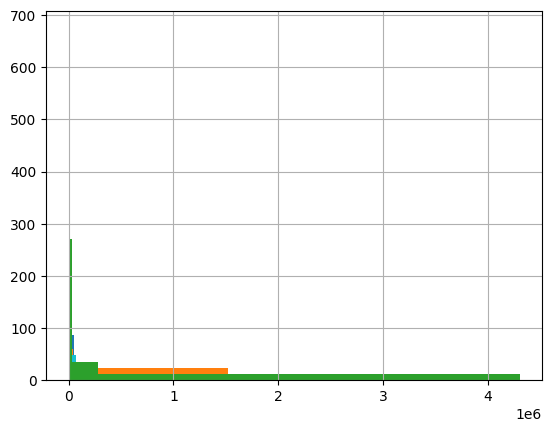

In [28]:
%%time
for col in periodic_cols:
    print(col)
    offer_bins = [seller_df[col].min(),1, seller_df[col].mean(), seller_df[col].mean() + std(seller_df[col]), seller_df[col].max() +1 ]
    seller_df[col].hist(bins=offer_bins)
    seller_df[col] = pd.cut(seller_df[col], offer_bins).cat.codes
seller_df.head()

offers_active_mp_total
offers_active_mp_ict
offers_active_mp_mro
offers_active_mp_bssa
offers_inactive_mp_total
offers_inactive_mp_mro
offers_inactive_mp_bssa
offers_active_oci_total
offers_active_oci_mro
CPU times: user 95.7 ms, sys: 1.97 ms, total: 97.6 ms
Wall time: 91.6 ms


,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,0,-1,-1,-1,-1,0,0,-1,-1,-1,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,8,1,2020,1,1,1999
1,49,-1,-1,-1,-1,2,2,3,-1,-1,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,27,7,2018,14,9,2018
2,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3,28,4,2021,1,1,1999
3,0,-1,-1,-1,-1,1,-1,1,-1,-1,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,7,9,2022,1,1,1999
4,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,26,3,2021,1,1,1999


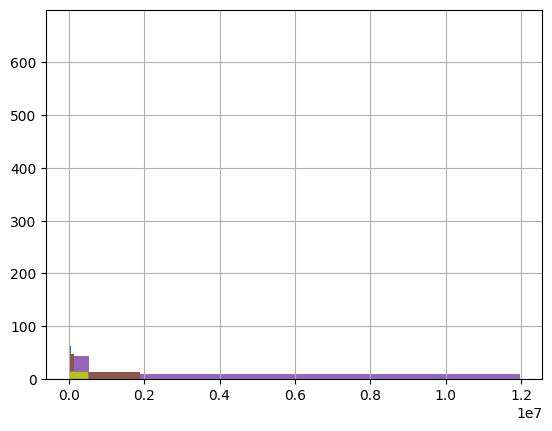

In [29]:
%%time
for col in offer_cols:
    print(col)
    offer_bins = [seller_df[col].min(),1 , seller_df[col].mean(), seller_df[col].mean() + std(seller_df[col]), seller_df[col].max() +1 ]
    seller_df[col].hist(bins=offer_bins)
    seller_df[col] = pd.cut(seller_df[col], offer_bins).cat.codes
seller_df.head()

In [30]:
order_cols

['ordered_units_mp_3m_total',
 'ordered_units_mp_3m_mro',
 'ordered_units_mp_12m_ict']

In [31]:
seller_df.ordered_units_mp_3m_total.min(), seller_df.ordered_units_mp_3m_total.mean(), seller_df.ordered_units_mp_3m_total.max(), std(seller_df.ordered_units_mp_3m_total)


(0.0, 1162.3045267489713, 83218.0, 5758.898652327955)

<AxesSubplot:>

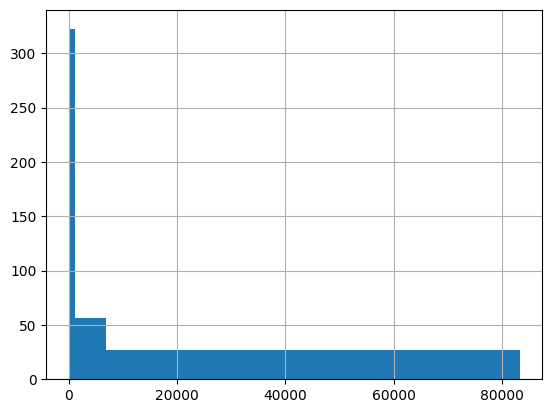

In [32]:
ordered_units_mp_3m_total_bins = [seller_df.ordered_units_mp_3m_total.min(),1 , seller_df.ordered_units_mp_3m_total.mean(), seller_df.ordered_units_mp_3m_total.mean() + std(seller_df.ordered_units_mp_3m_total), seller_df.ordered_units_mp_3m_total.max() +1 ]
seller_df.ordered_units_mp_3m_total.hist(bins=ordered_units_mp_3m_total_bins)


In [33]:
seller_df.ordered_units_mp_3m_total.value_counts(bins=ordered_units_mp_3m_total_bins)

(-0.001, 1.0]           334
(1.0, 1162.305]         312
(1162.305, 6921.203]    56 
(6921.203, 83219.0]     27 
Name: ordered_units_mp_3m_total, dtype: int64

ordered_units_mp_3m_total
ordered_units_mp_3m_mro
ordered_units_mp_12m_ict
CPU times: user 51.5 ms, sys: 6.49 ms, total: 58 ms
Wall time: 48.1 ms


,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,0,-1,-1,-1,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,8,1,2020,1,1,1999
1,49,-1,-1,-1,-1,2,2,3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,2,27,7,2018,14,9,2018
2,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,3,28,4,2021,1,1,1999
3,0,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,7,9,2022,1,1,1999
4,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,1,26,3,2021,1,1,1999


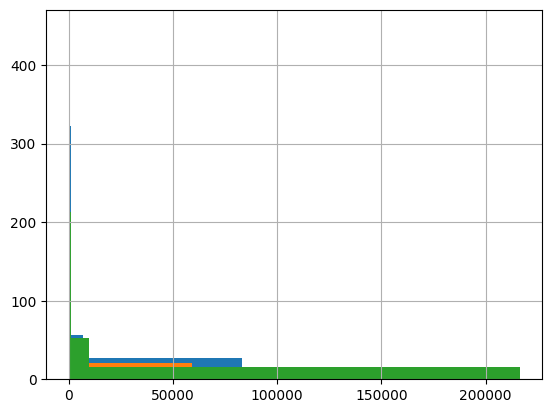

In [34]:
%%time
for col in order_cols:
    print(col)
    order_bins = [seller_df[col].min(), 1 , seller_df[col].mean(), seller_df[col].mean() + std(seller_df[col]), seller_df[col].max() +1 ]
    seller_df[col].hist(bins=order_bins)
    seller_df[col] = pd.cut(seller_df[col], order_bins).cat.codes
seller_df.head()

In [35]:
model_features = seller_df.columns
model_features

Index(['days_to_first_sale', 'offers_active_mp_total', 'offers_active_mp_ict',
       'offers_active_mp_mro', 'offers_active_mp_bssa',
       'offers_inactive_mp_total', 'offers_inactive_mp_mro',
       'offers_inactive_mp_bssa', 'offers_active_oci_total',
       'offers_active_oci_mro', 'ordered_units_mp_3m_total',
       'ordered_units_mp_3m_mro', 'ordered_units_mp_12m_ict',
       'sales_mp_1m_total', 'sales_mp_1m_ict', 'sales_mp_1m_mro',
       'sales_mp_1m_bssa', 'sales_mp_6m_none', 'sales_mp_12m_none',
       'sales_oci_3m_total', 'sales_oci_6m_mro', 'sales_oci_12m_bssa',
       'pdp_active_1m_total', 'pdp_active_3m_ict', 'pdp_active_3m_mro',
       'pdp_inactive_3m_mro', 'is_fds', 'company_type', 'date_created_day',
       'date_created_month', 'date_created_year', 'date_first_order_day',
       'date_first_order_month', 'date_first_order_year'],
      dtype='object')

In [36]:
len(model_features)

34

### Step 4: Running K-Means Clusters
**Run K-Means with different K-Values in range 4 and 12.**

In [37]:
K = range(4,12)

Counter({0: 200, 2: 200, 1: 200, 3: 129})
For n_clusters = 4 The average silhouette_score is : 0.3665493175189598
Counter({0: 200, 2: 200, 4: 200, 1: 102, 3: 27})
For n_clusters = 5 The average silhouette_score is : 0.41134590880041044
Counter({5: 200, 0: 200, 2: 173, 4: 97, 1: 39, 3: 20})
For n_clusters = 6 The average silhouette_score is : 0.4371971298277555
Counter({2: 200, 6: 200, 5: 166, 1: 92, 4: 30, 3: 21, 0: 20})
For n_clusters = 7 The average silhouette_score is : 0.4357809647367823
Counter({4: 200, 0: 144, 7: 135, 2: 102, 5: 78, 1: 29, 6: 21, 3: 20})
For n_clusters = 8 The average silhouette_score is : 0.407886880381582
Counter({5: 200, 0: 144, 3: 130, 6: 92, 2: 57, 8: 39, 1: 27, 7: 20, 4: 20})
For n_clusters = 9 The average silhouette_score is : 0.391138008000517
Counter({3: 200, 0: 130, 6: 104, 7: 87, 9: 58, 2: 48, 8: 36, 5: 26, 1: 20, 4: 20})
For n_clusters = 10 The average silhouette_score is : 0.36914345643688135
Counter({7: 160, 0: 130, 3: 114, 9: 105, 5: 63, 1: 48, 6: 

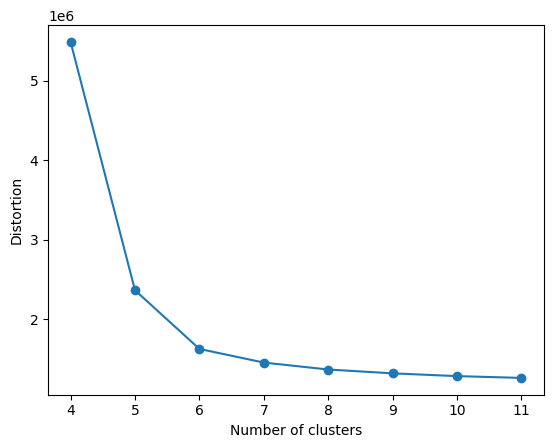

In [38]:
# predict the train dataset and print silhouette scores
inertias = []
for k in K:
    clf = KMeansConstrained(
             n_clusters=k,
             size_min=20,
             size_max=200,
             random_state=100
    )
    clf.fit_predict(seller_df)
    centers = clf.cluster_centers_
    inertias.append((k, clf.inertia_))
    #print(color.BOLD + str(k) + color.END)
    print(Counter(clf.labels_))
    silhouette_avg_kmeans = silhouette_score(seller_df, clf.labels_)
    print(color.BOLD + "For n_clusters =", str(clf.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

    
# plot ellbow curve for sum of squared distances to the closest center
plt.plot([x for (x, y) in inertias], [y for (x, y) in inertias], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [39]:
clf_5 = KMeansConstrained(
             n_clusters=5,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_5.fit_predict(seller_df)
centers_5 = clf_5.cluster_centers_
print(Counter(clf_5.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_5.labels_)
print(color.BOLD + "For n_clusters =", str(clf_5.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({0: 200, 2: 200, 4: 200, 1: 102, 3: 27})
For n_clusters = 5 The average silhouette_score is : 0.41134590880041044


In [40]:
clf_6 = KMeansConstrained(
             n_clusters=6,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_6.fit_predict(seller_df)
centers_6 = clf_6.cluster_centers_
print(Counter(clf_6.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_6.labels_)
print(color.BOLD + "For n_clusters =", str(clf_6.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({5: 200, 0: 200, 2: 173, 4: 97, 1: 39, 3: 20})
For n_clusters = 6 The average silhouette_score is : 0.4371971298277555


In [41]:
clf_7 = KMeansConstrained(
             n_clusters=7,
             size_min=20,
             size_max=200,
             random_state=100
)
clf_7.fit_predict(seller_df)
centers_7 = clf_7.cluster_centers_
print(Counter(clf_7.labels_))
silhouette_avg_kmeans = silhouette_score(seller_df, clf_7.labels_)
print(color.BOLD + "For n_clusters =", str(clf_7.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({2: 200, 6: 200, 5: 166, 1: 92, 4: 30, 3: 21, 0: 20})
For n_clusters = 7 The average silhouette_score is : 0.4357809647367823


**Create cluster and feature centroid dataframe**

In [42]:
df_7 = pd.DataFrame(centers_7, columns=model_features)
df_7.reset_index(inplace=True)
df_7 = df_7.rename(columns = {'index':'cluster_no'})
df_7['k_value'] = 7
###################
df_6 = pd.DataFrame(centers_6, columns=model_features)
df_6.reset_index(inplace=True)
df_6 = df_6.rename(columns = {'index':'cluster_no'})
df_6['k_value'] = 6
###################
df_5 = pd.DataFrame(centers_5, columns=model_features)
df_5.reset_index(inplace=True)
df_5 = df_5.rename(columns = {'index':'cluster_no'})
df_5['k_value'] = 5

df_7.head()

,cluster_no,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_inactive_mp_total,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_active_oci_total,offers_active_oci_mro,ordered_units_mp_3m_total,ordered_units_mp_3m_mro,ordered_units_mp_12m_ict,sales_mp_1m_total,sales_mp_1m_ict,sales_mp_1m_mro,sales_mp_1m_bssa,sales_mp_6m_none,sales_mp_12m_none,sales_oci_3m_total,sales_oci_6m_mro,sales_oci_12m_bssa,pdp_active_1m_total,pdp_active_3m_ict,pdp_active_3m_mro,pdp_inactive_3m_mro,is_fds,company_type,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year,k_value
0,0,7.059500e+02,1.100000,0.150000,7.500000e-01,0.200000,0.850000,0.700000,0.150000,-1.000000,-1.000000,0.600000,0.050000,-2.000000e-01,0.400000,-4.000000e-01,0.200000,-0.250000,-0.750000,-0.750000,-1.000000,-1.000000,-1.000000,0.900000,-1.000000e-01,6.500000e-01,0.350000,-4.163336e-17,2.900000,14.500000,6.000000,2019.800000,14.000000,7.000000,2021.650000,7
1,1,1.885652e+02,0.782609,0.086957,3.369565e-01,0.086957,0.956522,0.358696,0.076087,-0.934783,-0.945652,0.673913,0.152174,8.695652e-02,0.500000,-1.739130e-01,0.054348,-0.184783,-0.521739,-0.293478,-0.902174,-0.913043,-0.923913,0.630435,4.718448e-16,2.500000e-01,0.260870,3.260870e-02,2.706522,15.565217,6.065217,2020.521739,14.565217,6.423913,2021.010870,7
2,2,1.136868e-13,-0.825000,-0.920000,-9.250000e-01,-0.960000,-0.550000,-0.830000,-0.780000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.885000,-9.250000e-01,-9.300000e-01,-0.945000,5.000000e-03,2.550000,13.635000,6.390000,2020.965000,1.000000,1.000000,1999.000000,7
3,3,4.388571e+02,0.666667,0.142857,4.163336e-17,-0.285714,0.666667,0.047619,-0.238095,-0.857143,-0.904762,0.095238,-0.523810,-1.387779e-16,0.142857,1.665335e-16,-0.571429,-0.571429,-1.000000,-1.000000,-0.904762,-0.904762,-1.000000,0.523810,-1.942890e-16,-1.734723e-17,-0.238095,4.761905e-02,2.571429,17.904762,6.476190,2020.190476,14.857143,5.571429,2021.476190,7
4,4,3.107667e+02,1.033333,0.733333,7.333333e-01,0.400000,1.066667,0.666667,0.566667,-0.766667,-0.800000,0.866667,0.433333,5.333333e-01,0.766667,2.220446e-16,0.366667,0.133333,-0.400000,-0.300000,-0.800000,-0.800000,-0.800000,0.966667,5.666667e-01,6.333333e-01,0.566667,6.666667e-02,2.733333,16.166667,7.433333,2020.166667,14.566667,6.100000,2021.133333,7


In [43]:
#seller_base_df['seller_segments'] = clf.labels_
seller_df_5 = seller_base_df.copy()
seller_df_5['seller_segments'] = clf_5.labels_

seller_df_6 = seller_base_df.copy()
seller_df_6['seller_segments'] = clf_6.labels_

seller_df_7 = seller_base_df.copy()
seller_df_7['seller_segments'] = clf_7.labels_

In [44]:
df_7.shape,df_6.shape,df_5.shape

((7, 36), (6, 36), (5, 36))

In [45]:
# to append first dataframe at the end of second dataframe
centroid_df = df_7.append(df_6)
centroid_df = centroid_df.append(df_5)
centroid_df = centroid_df.astype(str)

centroid_df.shape, df_7.shape,df_6.shape,df_5.shape

((18, 36), (7, 36), (6, 36), (5, 36))

# Step 5: Export the results
In the final step we want to store the results to the GBQ. On the one hand we need the predicted segments but on the other hand we also want to make sure to save all the used elements as is. This is important for predicting in the future but also to reproduce results.

In [46]:
# TODO(developer): Set table_id to the ID of the table to fetch.

table_id_5 = 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_5'
table_id_6 = 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_6'
table_id_7 = 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_7'
centroid_table_id = 'ps-analytics-prod.eser.seller_segment_centroids_iteration_5'

table_list = [table_id_5, table_id_6, table_id_7]
seller_list = [seller_df_5, seller_df_6, seller_df_7]

for table in table_list:
    bqclient.delete_table(table, not_found_ok=True)  # Make an API request.
    print("Deleted table '{}'.".format(table))

print("###################")
print("Old tables were deleted.")
print("###################")

# Load data to BQ
for i in range(len(table_list)):
    job = bqclient.load_table_from_dataframe(seller_list[i], table_list[i])
    print("Table created '{}'.".format(table_list[i]))

Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_5'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_6'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_7'.
###################
Old tables were deleted.
###################
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_5'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_6'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_5_k_7'.


In [47]:
# Load centroid data of clusters to BQ

blankIndex=[''] * len(centroid_df)
centroid_df.index=blankIndex

# temporarily store the dataframe as a csv in a string variable
temp_csv_string = centroid_df.to_csv(sep=";", index=False)
temp_csv_string_IO = StringIO(temp_csv_string)

# create new dataframe from string variable
centroid_df = pd.read_csv(temp_csv_string_IO, sep=";")

# this new df can be uploaded to BQ with no issues
bqclient.delete_table(centroid_table_id, not_found_ok=True)  # Make an API request.
print("Deleted table '{}'.".format(centroid_table_id))


job = bqclient.load_table_from_dataframe(centroid_df, centroid_table_id)
print("Table created '{}'.".format(centroid_table_id))

Deleted table 'ps-analytics-prod.eser.seller_segment_centroids_iteration_5'.
Table created 'ps-analytics-prod.eser.seller_segment_centroids_iteration_5'.
